# Gender Classification 

In [1]:
!pip install --upgrade wandb

  Obtaining dependency information for wandb from https://files.pythonhosted.org/packages/28/3b/f1485df03e33a390b833081693e56be9e62fef097a82c26ef615605f768d/wandb-0.16.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.8 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.16.1
    Uninstalling wandb-0.16.1:
      Successfully uninstalled wandb-0.16.1


In [2]:
import os
import pandas as pd
import numpy as np
import cv2 as cv
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import wandb
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
gender_df_train="/kaggle/input/gender-classification-dataset/Training/"
gender_df_test="/kaggle/input/gender-classification-dataset/Validation"
fer_df_train="/kaggle/input/fer2013/train/"
fer_df_test="/kaggle/input/fer2013/test"

In [5]:
#For Training Dataset
train_datagen = ImageDataGenerator(
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))

train_gen=train_datagen.flow_from_directory(gender_df_train,
                                            target_size=(250,250),
                                            batch_size=48,
                                            class_mode='binary')

Found 47009 images belonging to 2 classes.


# Data Augmentation

1. To increase the data set size 
2. Helps overcome the “not enough data” issue, prevents overfitting, and makes the model perform better on previously unseen samples. 

In [6]:
import os
from keras.preprocessing import image

# Specify the directory where you want to save augmented images
augmented_dir = 'path/to/augmented_images'

# Create the directory if it doesn't exist
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)

# Number of augmented images to generate
num_augmented_images = 100  # You can adjust this based on your requirements

# Generate and save augmented images
for i in range(num_augmented_images):
    # Generate a batch of augmented images
    batch, labels = train_gen.next()

    # Save each augmented image in the batch to the new directory
    for j in range(len(batch)):
        img = image.array_to_img(batch[j])
        img.save(os.path.join(augmented_dir, f'augmented_image_{i * len(batch) + j}.png'))

In [7]:
import shutil

# Define a new directory for the combined dataset
combined_dir = 'path/to/training_combined_dataset'

# Create the combined directory if it doesn't exist
if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

# Copy original training images to the combined directory
original_train_dir = '/kaggle/input/gender-classification-dataset/Training/'
shutil.copytree(original_train_dir, os.path.join(combined_dir, 'original_training_images'))

# Copy augmented images to the combined directory
augmented_dir = 'path/to/augmented_images'
shutil.copytree(augmented_dir, os.path.join(combined_dir, 'augmented_images'))

'path/to/training_combined_dataset/augmented_images'

In [8]:
combined="/kaggle/working/path/to/training_combined_dataset"

In [9]:
import cv2 as cv
import os
import numpy as np

data_train = []
labels_train = []

new_width = 128
new_height = 128

# Access original training images
original_train_dir = '/kaggle/input/gender-classification-dataset/Training'
for class_label in os.listdir(original_train_dir):
    class_dir = os.path.join(original_train_dir, class_label)
    
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)

        # Read the image using OpenCV
        pic = cv.imread(file_path)

        # Check if the image was successfully loaded
        if pic is not None:
            # Convert the image to grayscale
            pic = cv.cvtColor(pic, cv.COLOR_BGR2GRAY)

            # Resize the image
            pic = cv.resize(pic, (new_width, new_height))

            # Append the image to the data_train list
            data_train.append(pic)

            # Extract the label from the subdirectory name
            label = 1 if class_label.lower() == "female" else 0
            labels_train.append(label)
        else:
            print(f"Error loading image: {file_path}")

# Access augmented images
augmented_subdir = os.path.join(combined_dir, 'augmented_images')
for filename in os.listdir(augmented_subdir):
    file_path = os.path.join(augmented_subdir, filename)

    # Read the image using OpenCV
    pic = cv.imread(file_path)

    # Check if the image was successfully loaded
    if pic is not None:
        # Convert the image to grayscale
        pic = cv.cvtColor(pic, cv.COLOR_BGR2GRAY)

        # Resize the image
        pic = cv.resize(pic, (new_width, new_height))

        # Append the image to the data_train list
        data_train.append(pic)

        # Extract the label from the filename
        label = 1 if "female" in filename else 0
        labels_train.append(label)
    else:
        print(f"Error loading image: {file_path}")

# Convert lists to NumPy arrays
data_train = np.array(data_train)
labels_train = np.array(labels_train)

In [10]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.utils import plot_model


In [11]:
# Define the VGGNet16 model
def create_vggnet16_model(input_shape=(128, 128, 1)):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(2, activation='softmax'))
    
    model.summary()
    plot_model(model)
    return model

In [12]:
dataset = np.array(data_train)
labels = np.array(labels_train)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)

run=wandb.init(project='gender-recognition-from-images',
              config={
                  'learning_rate':0.001,
                  'batch_size': 128,
                  'epochs': 10, 
                  'test_size' : 0.2})

config=wandb.config

# Create and compile the VGGNet16 model
model = create_vggnet16_model()
optimizer = tf.keras.optimizers.Adam(config.learning_rate)
model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Print test loss, test accuracy, train loss, train accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test)
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    
# Predict on test set
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

wandb: Currently logged in as: dishaa_s. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240128_083027-08y9jf01
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run silver-lake-33
wandb: ⭐️ View project at https://wandb.ai/dishaa_s/gender-recognition-from-images
wandb: 🚀 View run at https://wandb.ai/dishaa_s/gender-recognition-from-images/runs/08y9jf01


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                   

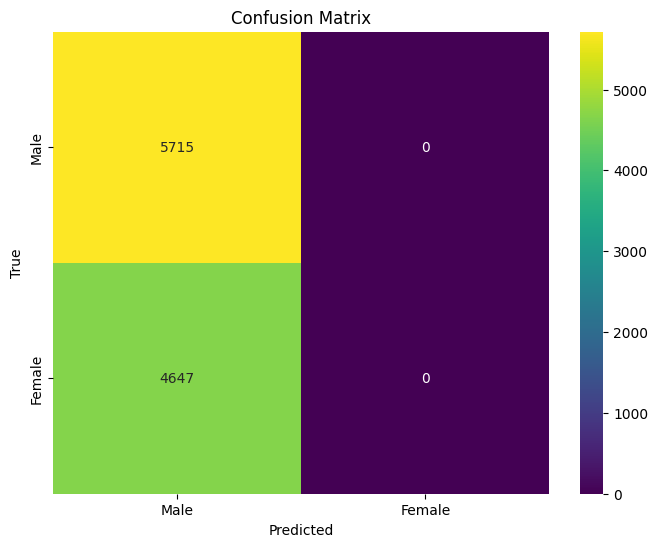

Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71      5715
           1       0.00      0.00      0.00      4647

    accuracy                           0.55     10362
   macro avg       0.28      0.50      0.36     10362
weighted avg       0.30      0.55      0.39     10362



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

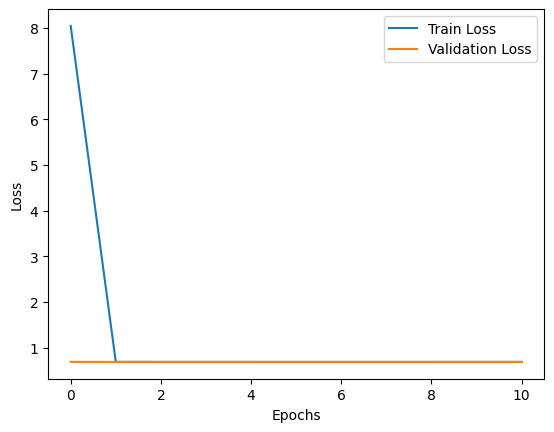

In [14]:
# Plot train loss and validation loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
model.save('model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
